# Proyecto de Pricing: Airbnb -Seattle

Elaborado por Marcela Huerfano en el marco del Diplomado en Inteligencia Artificial y Aprendizaje Profundo de la Universidad Nacional en 2020-II

Fecha de la última modificación: Sep 14 2020

# Contexto

## Base de Datos

Desde el 2.008 millones de usuarios alrededor del mundo usan la plataforma de Airbnb para buscar o publicitar espacios con el ánimo de arrendarlos, en la aplicación se observa la tarifa bruta junto con los valores variables como son impuestos, limpieza y depósito de seguridad. En [Kaggle](https://www.kaggle.com/airbnb/seattle) se encuentra disponible una base de esta platagoforma que recopila datos para la ciudad de Seattle compuesta por:
* Listings:  Incluye la descripción completa y la evaluación por espacio
* Reviews: Incluye un valor único por cada evaluación y comentarios detallados
* Calendar: Incluye el precio y disponibilidad de espacio por día.

## Objetivo

Diseñar un modelo de pricing para la tarifación bruta del arrendamiento de un espacio dadas sus caracteristicas, utilizando algoritmos de Deep Learning.

# Análisis Exploratorio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmplot
import folium
from folium.plugins import FastMarkerCluster
import seaborn as sns
sns.set()

### -Listings
Esta base contiene 3.818 registros de espacios publicitados a los cuales se les asocian 92 columnas relacionadas con nueve tipos de variables:
1. Descripción
2. Arrendatario
3. Geolocalización
4. Características
5. Precios 
6. Valores Adicionales
7. Calificación
8. Licencia
9. Políticas




In [2]:
listings=pd.read_csv('listings.csv')

In [3]:
listings.shape

(3818, 92)

In [4]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

#### Distribución Espacial

Los espacios están distribuido a lo largo de la ciudad, sin embargo un 52.2% se concentran al interior de cinco vecindarios: Capitol Hill(14.9%), Downtown (13.9%), Central Area (9.7%), Queen Anne (7.7%) y Ballard (6%).

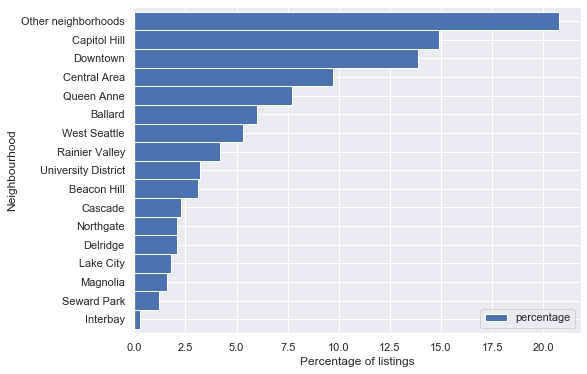

In [5]:
pivot = listings.pivot_table(index=['neighbourhood_group_cleansed'], values=['id'], aggfunc='count', margins=False)
pivot0=pivot.reset_index()
pivot0['percentage']= np.round(100* (pivot0['id']/pivot0['id'].sum()),1)

feq = pivot0[['neighbourhood_group_cleansed', 'percentage']].sort_values('percentage')
feq=feq.set_index('neighbourhood_group_cleansed')
feq.plot.barh(figsize=(8,6),  width= 1)
plt.xlabel('Percentage of listings', fontsize = 12)
plt.ylabel('Neighbourhood', fontsize = 12)
plt.show()


In [6]:
geo_location=listings[["latitude", "longitude"]]

In [7]:
locations = geo_location
map1 = folium.Map(location=[47.62, -122.33], zoom_start=12)
FastMarkerCluster(data=locations).add_to(map1)
map1

#### Tipos de espacios

90.1% de los anuncios corresponden a casas (45.4%) y apartamentos (44.7%), seguidos por 3.1% de casas de campo y 2.4% de Condominios.

In [8]:
pivot = listings.pivot_table(index=['property_type'], values=['id'], aggfunc='count', margins=False)
pivot1=pivot.reset_index()
pivot1['percentage']= np.round(100* (pivot1['id']/pivot1['id'].sum()),1)
pivot1.sort_values('percentage', ascending=False)

,property_type,id,percentage
9,House,1733,45.4
0,Apartment,1708,44.7
13,Townhouse,118,3.1
7,Condominium,91,2.4
1,Bed & Breakfast,37,1.0
10,Loft,40,1.0
4,Cabin,21,0.6
11,Other,22,0.6
3,Bungalow,13,0.3
5,Camper/RV,13,0.3


El promedio de precios es similar entre los diferentes tipos de propiedades. Las casas y apartamentos presentan la mayor cantidad de datos atípicos, sobresaliendo las casas por tener una mayor dispersión de precios en relación a los apartamentos. Los botes presentan la mayor diversificación de precios al interior de una misma categoría.

In [9]:
listings['price'] = listings['price'].str.replace("[$, ]", "").astype("float")

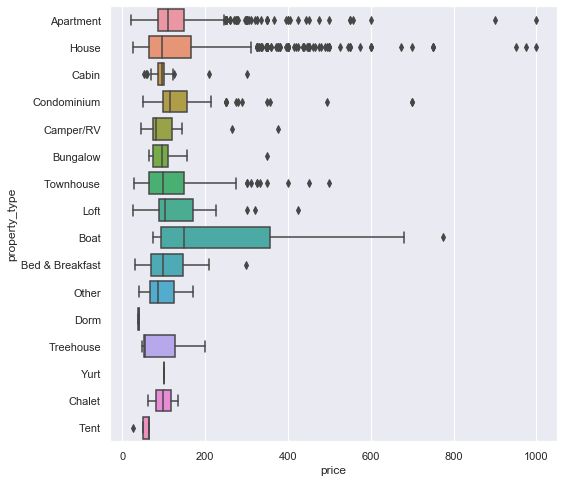

In [22]:
plt.figure(figsize=(8,8))
sns.boxplot(x="price", y="property_type", data=listings)
plt.show()

In [11]:
calendar=pd.read_csv('calendar.csv')

In [12]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [13]:
reviews=pd.read_csv('reviews.csv')

In [14]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...
